# Implementation of Knowledge Based SDDC LCM. 

#### Proposing a Knowledge Based Life Cycle Management method for the Infrastructure Components and the Applications in the Scaled Hyper Converged Software Defined Data Centers is a project to manage life cycle Management (LCM) software which will look for “Best Window time” or “best time” to perform Life Cycle Management.  So that the Administrator can perform LCM whenever upgrade or patch is available for any entity (Application or Infrastructure component) .  This will help avoid any risk because of ongoing  upgrades or patches 

### Import Library

In [84]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time
from time import strftime
from utils import util


In [85]:
__author__ = 'raviranjan'

### Define variables contants

In [86]:
LOG_DIR = "logs"
HOST_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
LOGGER_FILE_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
ERROR_PATTERN = 'ERROR:'
INFO_PATTERN = 'INFO:'
DEBUG_PATTERN = 'DEBUG:'
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
logger_file_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
has_error_pattern = r''
excel_file_path = "data/excel_data_1.xlsx"



# Create a util class

In [104]:
import re
import os
import time
from time import strftime


def export_to_file(dict_with_list_values=None, export_file_path=None, export_folder=None):
    """
    dict_with_list_values = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [32000,35000,37000,45000]
        }
    :param export_folder:
    :param dict_with_list_values:
    :param create_dict_from_list:
    :param column_name
    :return:
    """
    if not export_file_path:
        time_now = str(strftime("%Y-%m-%d %H-%M-%S", time.localtime()))
        export_file_path = export_folder + "/" + time_now + ".xlsx"
    columns = dict_with_list_values.keys()
    print('Exporting columns %s to %s' % (columns, export_file_path))
    import pandas as pd
    df = pd.DataFrame(dict_with_list_values, columns=columns)
    df.to_excel(export_file_path, index=False, header=True)
    print(export_file_path)
    return export_file_path


def extract_data_from_logs(log_files=None,
                           column_names=['time', 'info', 'error', 'debug', 'warn', 'exception',
                                         'filename', 'line'], add_time_stamp=True):
    excel_export_data = {
    }
    for column_name in column_names:
        excel_export_data[column_name] = []
    print("Define column %s" % excel_export_data)
    for log_file in log_files:
        with open(log_file) as f:
            for line in f:
                one_row_values = {}  # store one row value with key as column name and its value
                for column_name in column_names:
                    column_name = column_name.lower()
                    line = line.lower().strip()
                    if column_name in line:
                        cell_value = 1
                    else:
                        cell_value = 0
                    if column_name == "line":
                        cell_value = line
                    if column_name == "filename":
                        cell_value = log_file.split('/')[-1]
                    if add_time_stamp and column_name == "time":
                        RE_COMPILE_TIME_STAMP_PATTERN = "(24:00|2[0-3]:[0-5][0-9]|[0-1][0-9]:[0-5][0-9]:[0-5][0-9])"
                        cell_value = finditer_line(line, regex=RE_COMPILE_TIME_STAMP_PATTERN,
                                                   log_file=log_file)
                        if not cell_value:
                            line = replace_timestamp_with_time(line)
                            cell_value = finditer_line(line, regex=RE_COMPILE_TIME_STAMP_PATTERN,
                                                       log_file=log_file)
                        if not cell_value:
                            #TODO reparse
                            pass

                    # Final cell value for that column
                    one_row_values[column_name] = cell_value

                for column_name in one_row_values:
                    # append the list value
                    existing_one_column_values = excel_export_data[column_name]
                    existing_one_column_values.append(one_row_values[column_name])
                    excel_export_data[column_name] = existing_one_column_values
    files = []
    for log_file in log_files:
        log_file = log_file.split('/')[-1]
        files.append(log_file)
    for column_name in column_names:
        print("Total %s values for Column:%s in all log files" % (
        len(excel_export_data[column_name]), column_name))

    return excel_export_data


def get_log_files(log_dir):
    log_files = []
    for root, dir_, files in os.walk(log_dir):
        for sub_dir in dir_:
            sub_dir_path = os.path.join(root, sub_dir)
            # print("sub_dir: %s" % sub_dir_path)
            # os.system('ls %s' % sub_dir_path)
        for f in files:
            f_path = os.path.join(root, f)
            if ".log" in f_path:
                log_files.append(f_path)
    print("%s" % (log_files))
    return log_files


def findall_(log_file, regex):
    matched_lines = []
    with open(log_file) as f:
        # lines = f.readlines()
        for line in f:
            found = re.findall(regex, line)
            if found:
                matched_lines.append(line)
        print(matched_lines)
    return matched_lines


def search_re(line, pattern=None):
    # Python program to illustrate
    # Matching regex objects
    match = re.match(pattern, line)
    if not match:
        regex_com = re.compile(pattern)
        match = regex_com.search(line)
        if match:
            value = match.group()
            print('found using re.compile: %s' % value)
            return value
        else:
            print('%s not Found using re.compile also:' % pattern)
            return ''
    else:
        value = match.group()
        print('Found using re.match: %s' % value)
        return value


def finditer_(log_file_path, regex, read_line=True):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    with open(log_file_path, "r") as f:
        match_list = []
        if read_line:
            for line in f:
                for match in re.finditer(regex, line, re.S):
                    match_text = match.group()
                    match_list.append(match_text)
        else:
            data = f.read()
            for match in re.finditer(regex, data, re.S):
                match_text = match.group()
                match_list.append(match_text)
    f.close()
    print(match_list)
    return match_list


def finditer_line(line, regex, log_file=None):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    match_text = ''
    for match in re.finditer(regex, line, re.S):
        match_text = match.group()
    return match_text


def count_cell_entries(df, col_name='', output_col_name=''):
    """
    Returns pd.value_counts() as a DataFrame

    Parameters
    ----------
    df : Pandas Dataframe
        Dataframe on which to run value_counts(), must have column `col`.
    col : str
        Name of column in `df` for which to generate counts

    Returns
    -------
    Pandas Dataframe
        Returned dataframe will have a single column named "count" which contains the count_values()
        for each unique value of df[col]. The index name of this dataframe is `col`.

    Example
    -------
    >>> value_counts_df(pd.DataFrame({'a':[1, 1, 2, 2, 2]}), 'a')
       count
    a
    2      3
    1      2
    """
    # df = pd.DataFrame(df[col].value_counts())
    # df.index.name = col
    # df.columns = ['count']
    z = df[col_name].value_counts()
    z1 = z.to_dict()  # converts to dictionary
    df[output_col_name] = df[col_name].map(z1)
    return df


def date2int(df):
    if df.timestamp:
        t = df['time']
        try:
            t1 = t.timetuple()
            return int(time.mktime(t1))
        except ValueError:
            return None


def timestamp2date(timestamp):
    from datetime import datetime
    return datetime.fromtimestamp(int(timestamp))


def replace_timestamp_with_time(line):
    if line.startswith('-'):
        tmp = line[line.index('-') + len('-'):].strip()
    elif line.startswith(' -'):
        tmp = line[line.index('-') + len('-'):].strip()
    else:
        tmp = line
    tmp = tmp.split(" ")
    if tmp:
        tmp = tmp[0]
        if tmp.isnumeric():
            time = timestamp2date(tmp)
            line = line.replace(tmp, str(time))
    return line


### Get all components log files

In [105]:
log_files = get_log_files(log_dir=LOG_DIR)

['logs/HDFS/HDFS.log', 'logs/Windows/Windows.log', 'logs/Apache/Apache.log', 'logs/HealthApp/HealthApp.log', 'logs/Thunderbird/Thunderbird.log', 'logs/Spark/Spark.log', 'logs/Mac/Mac.log', 'logs/BGL/BGL.log', 'logs/Andriod/Andriod.log', 'logs/Hadoop/Hadoop.log', 'logs/Proxifier/Proxifier.log', 'logs/HPC/HPC.log', 'logs/Linux/Linux.log', 'logs/Zookeeper/Zookeeper.log', 'logs/OpenStack/OpenStack.log', 'logs/OpenSSH/SSH.log']


### read logs and dumps/export to Excel 

In [106]:
excel_export_data = extract_data_from_logs(log_files=log_files, column_names=['time', 'info', 'error', 'debug', 'warn', 'exception', 'filename', 'line'])

Define column {'time': [], 'info': [], 'error': [], 'debug': [], 'warn': [], 'exception': [], 'filename': [], 'line': []}
Total 32000 values for Column:time in all log files
Total 32000 values for Column:info in all log files
Total 32000 values for Column:error in all log files
Total 32000 values for Column:debug in all log files
Total 32000 values for Column:warn in all log files
Total 32000 values for Column:exception in all log files
Total 32000 values for Column:filename in all log files
Total 32000 values for Column:line in all log files


In [107]:
#export_to_file(dict_with_list_values=excel_export_data, export_file_path=excel_file_path)

# Analyzing Data

## Read the Exported Excel file

In [108]:
import time
print(excel_file_path)
df = pd.read_excel(excel_file_path)

data/excel_data_1.xlsx


In [109]:
df.head(50)

,time,info,error,debug,warn,exception,filename,line
0,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:606|step_lsc|30002312|onstan...
1,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:615|step_lsc|30002312|onexte...
2,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:633|step_standreportreceiver...
3,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_lsc|30002312|proces...
4,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_standstepcounter|30...
5,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_sputils|30002312| g...
6,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:636|step_sputils|30002312|se...
7,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:636|step_lsc|30002312|onstan...
8,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:645|step_extsdm|30002312|cal...
9,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:648|step_extsdm|30002312|cal...


## Add time along with  timestamp

In [110]:
# create a new column time and conver timestamp to time
df["timestamp"] = [time.mktime(t.timetuple()) if not pd.isnull(t) else None  for t in pd.to_datetime(df['time'], format='%M:%S', errors='coerce')]
df.head(500)

,time,info,error,debug,warn,exception,filename,line,timestamp
0,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:606|step_lsc|30002312|onstan...,-2.208987e+09
1,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:615|step_lsc|30002312|onexte...,-2.208987e+09
2,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:633|step_standreportreceiver...,-2.208987e+09
3,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_lsc|30002312|proces...,-2.208987e+09
4,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_standstepcounter|30...,-2.208987e+09
...,...,...,...,...,...,...,...,...,...
495,22:17,0,0,0,0,0,HealthApp.log,20171223-22:17:51:161|step_extsdm|30002312|cal...,-2.208987e+09
496,22:17,0,0,0,0,0,HealthApp.log,20171223-22:17:51:165|step_standreportreceiver...,-2.208987e+09
497,22:17,0,0,0,0,0,HealthApp.log,20171223-22:17:51:362|step_lsc|30002312|onstan...,-2.208987e+09
498,22:17,0,0,0,0,0,HealthApp.log,20171223-22:17:51:370|step_lsc|30002312|onexte...,-2.208987e+09


## Count , how many logs entries of given timestamp

## Hold the value in timestamp_count

In [111]:
count_cell_entries(df, col_name='time', output_col_name='time_count')


,time,info,error,debug,warn,exception,filename,line,timestamp,time_count
0,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:606|step_lsc|30002312|onstan...,-2.208987e+09,316.0
1,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:615|step_lsc|30002312|onexte...,-2.208987e+09,316.0
2,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:633|step_standreportreceiver...,-2.208987e+09,316.0
3,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_lsc|30002312|proces...,-2.208987e+09,316.0
4,22:15,0,0,0,0,0,HealthApp.log,20171223-22:15:29:635|step_standstepcounter|30...,-2.208987e+09,316.0
...,...,...,...,...,...,...,...,...,...,...
31995,20:11,1,0,0,0,0,Spark.log,17/06/09 20:11:11 info storage.blockmanager: f...,-2.208988e+09,914.0
31996,20:11,1,0,0,0,0,Spark.log,17/06/09 20:11:11 info executor.executor: fini...,-2.208988e+09,914.0
31997,20:11,1,0,0,0,0,Spark.log,17/06/09 20:11:11 info executor.coarsegrainede...,-2.208988e+09,914.0
31998,20:11,1,0,0,0,0,Spark.log,17/06/09 20:11:11 info executor.executor: runn...,-2.208988e+09,914.0


### sort by timestamp_count

In [112]:
df = df.sort_values(by=['time_count'], ascending=False)
df

,time,info,error,debug,warn,exception,filename,line,timestamp,time_count
30991,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:58 info output.fileoutputcommit...,-2.208988e+09,1101.0
30669,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:56 info executor.executor: fini...,-2.208988e+09,1101.0
30656,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info executor.executor: runn...,-2.208988e+09,1101.0
30657,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info storage.memorystore: bl...,-2.208988e+09,1101.0
30658,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info broadcast.torrentbroadc...,-2.208988e+09,1101.0
...,...,...,...,...,...,...,...,...,...,...
23995,NaN,1,1,0,0,0,BGL.log,- 1135665476 2005.12.26 r37-m1-nc-c:j02-u11 20...,NaN,NaN
23996,NaN,1,1,0,0,0,BGL.log,- 1135669430 2005.12.26 r37-m1-nc-c:j02-u11 20...,NaN,NaN
23997,NaN,1,1,0,0,0,BGL.log,- 1135669517 2005.12.26 r37-m1-nc-c:j02-u11 20...,NaN,NaN
23998,NaN,1,1,0,0,0,BGL.log,- 1135675498 2005.12.27 r37-m1-nc-c:j02-u11 20...,NaN,NaN


## Draw  Plots and Graph


### How many rows having error value

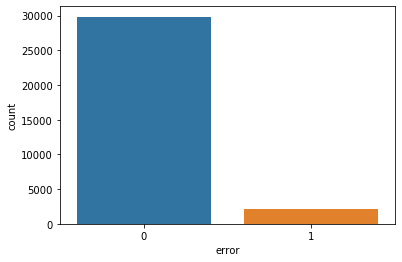

In [113]:
sns.countplot(x="error", data=df)

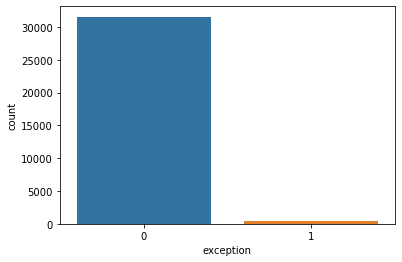

In [114]:
# how many rows having exception value
sns.countplot(x="exception", data=df)

#  Data Wrangling


## Data Wrangling is to remove null or empty data, cleaning data set

In [115]:
print((df.info()))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32000 entries, 30991 to 23999
Data columns (total 10 columns):
time          25793 non-null object
info          32000 non-null int64
error         32000 non-null int64
debug         32000 non-null int64
warn          32000 non-null int64
exception     32000 non-null int64
filename      32000 non-null object
line          32000 non-null object
timestamp     5268 non-null float64
time_count    25793 non-null float64
dtypes: float64(2), int64(5), object(3)
memory usage: 3.9+ MB
None


In [116]:
df.isnull().sum()



time           6207
info              0
error             0
debug             0
warn              0
exception         0
filename          0
line              0
timestamp     26732
time_count     6207
dtype: int64

In [106]:
df.head(5)
df.isnull().sum()


timestamp           6207
info                   0
error                  0
debug                  0
warn                   0
exception              0
filename               0
line                   0
time               26732
timestamp_count     6207
dtype: int64

## either drop null row or fill some value where value is null


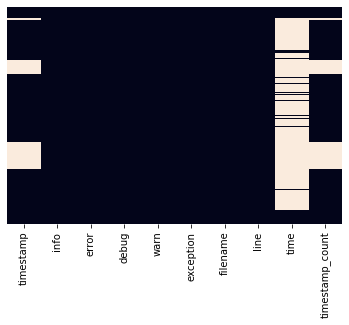

In [108]:
df.drop("line", axis=1, inplace=True)


In [57]:
df.isnull().sum()


timestamp           6207
info                   0
error                  0
debug                  0
warn                   0
exception              0
filename               0
line                   0
time               26732
timestamp_count     6207
dtype: int64

In [58]:
df.head(5)


,timestamp,info,error,debug,warn,exception,filename,line,time,timestamp_count
30991,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:58 info output.fileoutputcommit...,-2.208988e+09,1101.0
30669,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:56 info executor.executor: fini...,-2.208988e+09,1101.0
30656,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info executor.executor: runn...,-2.208988e+09,1101.0
30657,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info storage.memorystore: bl...,-2.208988e+09,1101.0
30658,20:10,1,0,0,0,0,Spark.log,17/06/09 20:10:55 info broadcast.torrentbroadc...,-2.208988e+09,1101.0


## Remove non required columns

In [ ]:
df.drop(['info'], axis=True, inplace=True)
df.drop("filename", axis=1, inplace=True)

### hold column values in variable


In [110]:
info=pd.get_dummies(df['info'])

In [111]:
df = pd.concat([df, info], axis=1)


,timestamp,info,error,debug,warn,exception,filename,time,timestamp_count,0,1
30991,20:10,1,0,0,0,0,Spark.log,-2.208988e+09,1101.0,0,1
30072,20:10,1,0,0,0,0,Spark.log,-2.208988e+09,1101.0,0,1
30066,20:10,1,0,0,0,0,Spark.log,-2.208988e+09,1101.0,0,1
30067,20:10,1,0,0,0,0,Spark.log,-2.208988e+09,1101.0,0,1
30068,20:10,1,0,0,0,0,Spark.log,-2.208988e+09,1101.0,0,1


#  Train and Test

In [57]:
X = df.drop("error", axis=1)
y = df["error"]

In [58]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [60]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

In [61]:
logmodel.fit(X_train, y_train)


LogisticRegression()

In [62]:
predictions = logmodel.predict(X_test)

In [63]:
from sklearn.metrics import classification_report
classification_report(y_test, predictions)


/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/raviranjan/Documents/workspace/lanier-goat/venv3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

'              precision    recall  f1-score   support\n\n           0       0.93      1.00      0.97      9870\n           1       0.00      0.00      0.00       690\n\n    accuracy                           0.93     10560\n   macro avg       0.47      0.50      0.48     10560\nweighted avg       0.87      0.93      0.90     10560\n'

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


array([[9870,    0],
       [ 690,    0]])

In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)


0.9346590909090909

#  Collecting Data


# Accuracy Check
